In [25]:
from sklearn.svm import SVR, LinearSVR
import pandas as pd
import numpy as np
import matplotlib
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut, GridSearchCV
from sklearn import preprocessing
import seaborn as sns
import scipy.stats as stats
import scipy.io as sio
import sklearn
import sys
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr, spearmanr, permutation_test # need python3.8
import warnings
from pycirclize import Circos
warnings.filterwarnings('ignore')

In [26]:
def compute_statistic(x, y):
    return stats.pearsonr(x, y)[0]

In [27]:
# Load data
featurepath='/media/shuang/data/BrainAge/Brain_age_scripts/network_features/'
hc_fc_data = pd.read_csv(featurepath+'FC_HC_mean.csv', header=None)
hc_sc_data = pd.read_csv(featurepath+'SC_HC_mean.csv', header=None)
hc_msn_data = pd.read_csv(featurepath+'MSN_HC_mean.csv', header=None)
hc_age_data = pd.read_excel('/media/shuang/data/BrainAge/Brain_age_scripts/data/HC_age.xlsx')
eos_fc_data = pd.read_csv(featurepath+'FC_EOS_mean.csv', header=None)
eos_sc_data = pd.read_csv(featurepath+'SC_EOS_mean.csv', header=None)
eos_msn_data = pd.read_csv(featurepath+'MSN_EOS_mean.csv', header=None)
eos_age_data = pd.read_excel('/media/shuang/data/BrainAge/Brain_age_scripts/data/EOS_age.xlsx')

hc_fc_data = np.array(hc_fc_data.iloc[2:, :])
hc_sc_data = np.array(hc_sc_data.iloc[2:, :])
hc_msn_data = np.array(hc_msn_data.iloc[2:, :])
hc_age_data = np.array(hc_age_data)
eos_fc_data = np.array(eos_fc_data.iloc[2:, :])
eos_sc_data = np.array(eos_sc_data.iloc[2:, :])
eos_msn_data = np.array(eos_msn_data.iloc[2:, :])
eos_age_data = np.array(eos_age_data)

In [28]:
# Choose one modal data
hc_data = np.concatenate((hc_fc_data, hc_sc_data, hc_msn_data), axis=1)
eos_data = np.concatenate((eos_fc_data, eos_sc_data, eos_msn_data), axis=1)

In [29]:
# Normalized data
y_hc = hc_age_data[:, 0]
y_eos = eos_age_data[:, 0]
min_max_scaler = preprocessing.StandardScaler()
min_max_scaler = min_max_scaler.fit(hc_data) # fit training set
x_hc = min_max_scaler.transform(hc_data) 
x_eos = min_max_scaler.transform(eos_data)
t_value = stats.ttest_ind(x_hc,x_eos)
t_value = t_value.statistic
print(x_hc.shape, x_eos.shape)

(91, 759) (80, 759)


In [30]:
# For FC: exclude headmotion influence
x_hc_fc=x_hc[:,0:253]
select_ind = range(0,x_hc_fc.shape[1])
head_motion = sio.loadmat('/media/shuang/data/BrainAge/Brain_age_scripts/data/head_motion.mat')['head_motion']
head_motion = np.array(head_motion)
# Initialize rr array
rr = np.zeros((x_hc_fc.shape[1], 2))
for i in range(x_hc_fc.shape[1]):
    feature = x_hc_fc[:,i]
    r, p = pearsonr(feature, head_motion[:, 0])
    rr[i, :] = [r, p]
# Count number of features with p-value > 0.05
pv = 0.05
a = np.where(rr[:, 1] > pv)[0]
# Find indices of features with p-value < 0.05
b = np.where(rr[:, 1] < pv)[0] # a + b = FC features
print('p < 0.05: ', b.shape[0])
print('p > 0.05: ', np.array(select_ind)[a])
c = np.array(select_ind)[a]
print('selected features without head motion: ', len(c))

p < 0.05:  125
p > 0.05:  [  1   3   4   5   6   7  10  12  13  14  15  17  18  19  20  21  26  28
  29  30  31  32  33  34  36  37  38  41  43  44  45  47  48  67  68  69
  70  71  72  73  74  76  88  92  94  95  98 100 101 102 104 105 106 107
 110 113 114 115 117 118 120 123 126 132 137 140 141 143 146 152 155 156
 163 164 168 170 171 173 175 176 177 179 180 181 182 185 187 188 189 190
 191 193 194 195 196 197 198 199 200 202 203 205 206 207 208 209 210 211
 212 213 214 216 222 225 226 227 231 232 233 235 236 242 244 245 246 247
 251 252]
selected features without head motion:  128


In [31]:
# Select FC features
select_id = sio.loadmat('/media/shuang/data/BrainAge/Brain_age_scripts/output/FeaturesS_FC_RF.mat')['saved_fcidx'][0, :]
print('selected features by RFECV: ', len(select_id))
common_id = [x for x in select_id if x in c]
common_id = np. array(common_id)
print('selected features: ', len(common_id))
#x_hc = x_hc[:, common_id]
#x_eos = x_eos[:, common_id]
#print('selected features HC ', x_hc.shape)
#print('selected features EOS ', x_eos.shape)

selected features by RFECV:  249
selected features:  128


In [32]:
# Select SC features
select_id = sio.loadmat('/media/shuang/data/BrainAge/Brain_age_scripts/output/FeaturesS_SC_RF.mat')['saved_scidx'][0, :]
print(len(select_id))
select_id=select_id+253
common_id=np.concatenate((common_id,select_id),axis=0)
print('selected features: ', len(common_id))

12
selected features:  140


In [33]:
# Select MSN features
select_id = sio.loadmat('/media/shuang/data/BrainAge/Brain_age_scripts/output/FeaturesS_MSN_RF.mat')['saved_msnidx'][0, :]
print(len(select_id))
select_id=select_id+253+253
common_id=np.concatenate((common_id,select_id),axis=0)
print('selected features: ', len(common_id))

36
selected features:  176


In [35]:
# Predicting
y_pred_hc = np.zeros((y_hc.shape[0],))
# repeat 50 times; 10 fold cv
num_folds = 10
num_repeats = 50
all_y_pred_hc = np.zeros((num_repeats, y_hc.shape[0]))
all_y_pred_eos = np.zeros((num_repeats, num_folds, y_eos.shape[0]))
coef = np.zeros((num_repeats, num_folds, x_hc.shape[1]))
param_grid={"n_estimators":np.linspace(50,400,50, dtype=int),"max_depth":np.linspace(8,16,2, dtype=int)}
count = 0
for repeat in range(num_repeats):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=repeat)
    k = 0
    print(count)
    for train_index, test_index in kf.split(x_hc):
        estimator = RandomForestRegressor()
        X_train, X_test = x_hc[train_index], x_hc[test_index]
        y_train, y_test = y_hc[train_index], y_hc[test_index]
        # Select features survive REFCV
        select_index = common_id
        X_train = np.array(X_train)[:,select_index]
        X_test = np.array(X_test)[:,select_index]
        # training model
        grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        # predicting test data of HC
        best_model = grid_search.best_estimator_
        print(grid_search.best_params_)
        y_pred_hc = best_model.predict(X_test)
        coef[repeat,k,select_index] = best_model.feature_importances_
        print(y_pred_hc.shape)
        all_y_pred_hc[repeat, test_index] = y_pred_hc
        # predicting EOS data
        x_eos_sf = np.array(x_eos)[:,select_index] # selected features
        y_pred_eos = best_model.predict(x_eos_sf)
        all_y_pred_eos[repeat, k, :] = y_pred_eos
        k = k + 1
        count = count + 1

0
{'max_depth': 8, 'n_estimators': 57}
(10,)
{'max_depth': 8, 'n_estimators': 114}
(9,)
{'max_depth': 16, 'n_estimators': 92}
(9,)
{'max_depth': 16, 'n_estimators': 92}
(9,)
{'max_depth': 16, 'n_estimators': 50}
(9,)
{'max_depth': 16, 'n_estimators': 214}
(9,)
{'max_depth': 8, 'n_estimators': 207}
(9,)
{'max_depth': 8, 'n_estimators': 150}
(9,)
{'max_depth': 8, 'n_estimators': 100}
(9,)
{'max_depth': 16, 'n_estimators': 178}
(9,)
10
{'max_depth': 16, 'n_estimators': 57}
(10,)
{'max_depth': 16, 'n_estimators': 50}
(9,)
{'max_depth': 8, 'n_estimators': 71}
(9,)
{'max_depth': 16, 'n_estimators': 57}
(9,)
{'max_depth': 8, 'n_estimators': 128}
(9,)
{'max_depth': 8, 'n_estimators': 157}
(9,)
{'max_depth': 8, 'n_estimators': 78}
(9,)
{'max_depth': 16, 'n_estimators': 257}
(9,)
{'max_depth': 16, 'n_estimators': 50}
(9,)
{'max_depth': 8, 'n_estimators': 171}
(9,)
20
{'max_depth': 8, 'n_estimators': 64}
(10,)
{'max_depth': 8, 'n_estimators': 142}
(9,)
{'max_depth': 16, 'n_estimators': 50}
(9,)
{

In [36]:
y_pred_eos_50 = np.mean(all_y_pred_eos, axis=1)
HC_pearson_perm = np.zeros((all_y_pred_hc.shape[0],2))
EOS_pearson_perm = np.zeros((all_y_pred_hc.shape[0],2))
HC_MAE = np.zeros((all_y_pred_hc.shape[0]))
EOS_MAE = np.zeros((all_y_pred_hc.shape[0]))
HC_R2 = np.zeros((all_y_pred_hc.shape[0]))
EOS_R2 = np.zeros((all_y_pred_hc.shape[0]))
for i in range(all_y_pred_hc.shape[0]):
        temp = stats.pearsonr(y_hc, all_y_pred_hc[i,:])
        HC_pearson_perm[i,0] = temp.statistic
        HC_pearson_perm[i,1] = temp.pvalue
        temp = stats.pearsonr(y_eos, y_pred_eos_50[i,:])
        EOS_pearson_perm[i,0] = temp.statistic
        EOS_pearson_perm[i,1] = temp.pvalue
        HC_MAE[i] = sklearn.metrics.mean_absolute_error(y_hc, all_y_pred_hc[i,:])
        EOS_MAE[i] = sklearn.metrics.mean_absolute_error(y_eos, y_pred_eos_50[i,:])
        HC_R2[i] = sklearn.metrics.r2_score(y_hc, all_y_pred_hc[i,:])
        EOS_R2[i] = sklearn.metrics.r2_score(y_eos, y_pred_eos_50[i,:])

In [37]:
# Correlation with PANSS scores
select_id_panss = pd.read_csv('/media/shuang/data/BrainAge/Brain_age_scripts/data/select_id_panss.csv', header=None)
select_id_panss = select_id_panss[0]
panss = pd.read_csv('/media/shuang/data/BrainAge/Brain_age_scripts/data/panss_59.csv', header=None)
brainage_panss=y_pred_eos_50[:,select_id_panss]

In [49]:
# Loading PANSS scores
select_id_panss = pd.read_csv('/media/shuang/data/BrainAge/Glasser360/select_id_panss.csv', header=None)
select_id_panss = select_id_panss[0]
panss = pd.read_csv('/media/shuang/data/BrainAge/Glasser360/panss_59.csv', header=None)
brainage_panss=y_pred_eos_50[:,select_id_panss]
agegap_panss=agegap_eos[:,select_id_panss]

r mean: [0.15815825 0.26787985 0.10831646 0.23794759 0.22502992]
r std: [0.00710796 0.00625021 0.00710677 0.00833677 0.00703699]
p mean: [0.23221768 0.04048164 0.41481623 0.07014169 0.08707619]
p std: [0.02142914 0.00483522 0.03083585 0.01012449 0.01029156]


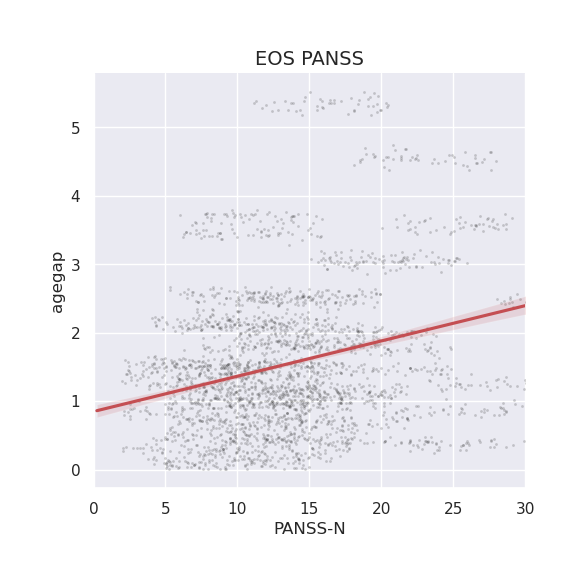

In [52]:
# Pearson's r vaules between age gap and panss
panss_corr=np.zeros((agegap_panss.shape[0],panss.shape[1]))
panss_corrp=np.zeros((agegap_panss.shape[0],panss.shape[1]))
for i in range(agegap_panss.shape[0]):
    for j in range(panss.shape[1]):
        temp = stats.pearsonr(panss.loc[:,j], np.abs(agegap_panss[i,:]))
        #temp = stats.spearmanr(panss.loc[:,j], np.abs(agegap_panss[i,:]))
        panss_corr[i,j] = temp.statistic
        panss_corrp[i,j] = temp.pvalue
print('r mean:',np.mean(panss_corr,axis=0))
print('r std:',np.std(panss_corr,axis=0))
print('p mean:',np.mean(panss_corrp,axis=0))
print('p std:',np.std(panss_corrp,axis=0))
# plotting correlation between brain age and panss
plotdata = np.zeros((agegap_panss.shape[0]*agegap_panss.shape[1],6))
count = 0
for i in range(agegap_panss.shape[1]):
    plotdata[count:count+agegap_panss.shape[0],0:5] = [panss.loc[i,:]]*agegap_panss.shape[0]
    plotdata[count:count+agegap_panss.shape[0],5] = np.abs(agegap_panss[:,i])
    count = count + agegap_panss.shape[0]
plotdata=pd.DataFrame(plotdata)
plotdata.rename(columns={0: 'PANSS-P',1: 'PANSS-N',2: 'PANSS-G',3: 'PANSS-S',4: 'PANSS-T', 5: 'agegap'}, inplace=True) 
sns.set_theme(style="darkgrid")
# plot brain age and actual age
g=sns.catplot(
    data=plotdata, x='PANSS-N', y='agegap', size=2,jitter=5,alpha=0.2,
    native_scale=True, zorder=1, color="k" ) # zorder for its priority
sns.regplot(
    data=plotdata, x='PANSS-N', y='agegap', ci=95, ax=g.ax,
    scatter=False, truncate=False, order=1, color="r")
g.ax.set_title('EOS PANSS', fontsize=14)
#g.ax.set_xlim(30,120)
g.ax.set_xlim(0,30)
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/PANSSNall_nodelete.svg')